In [1]:
using DataFrames


INFO: Precompiling module DataFrames.


In [53]:
using IterativeSolvers
using PyPlot
using MatrixMarket

In [54]:
function  prolongation1(A)
    n = size(A,1)
    r = floor(Int, n/2) 
    R = zeros(r,n)
    i = 1
    j = 1
    while i <= r 
        R[i,j] = 1
        i = i + 1
        j = j + 2
    end
    return R
end

prolongation1 (generic function with 1 method)

In [55]:
function  prolongation2(A)
    n = size(A,1)
    r = floor(Int, n/2)
    R = zeros(r,n)
    i = 1
    j = 1
    while i <= r 
        R[i,j] = 1
        if(j+1 <= n)
            R[i,j+1] = 2
        end
        if(j+2 <= n)
            R[i,j+2] = 1
        end
        i = i + 1
        j = j + 2
    end
    return 1/4*R
end

prolongation2 (generic function with 1 method)

In [87]:
# Solves the System Ax=b with de Deflation-Operator R
function solve(A, b, R)
    # Compute A = M - N
    n = size(A,1)
    
    P = transpose(R)
    
    PAR = P*inv(R*A*P)*R
    
    PN = I - A * PAR + PAR
    
    gmres(A, b; tol = 0.0001, Pl = lufact(PN), log = true)   
end

solve (generic function with 1 method)

In [88]:
function getA()
    mmread("fidap005.mtx")
end

getA (generic function with 1 method)

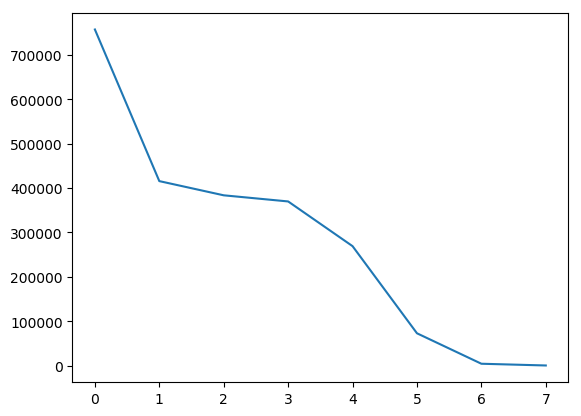

[1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0]Converged after 8 iterations.

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000050D8B898>

In [93]:
A = getA()
x, history = solve(A, ones(Float64, size(A,1),1), prolongation1(A))
print(ones(Float64, size(A,1),1))
print(history)
#keys(history.data)
plot(history.data[:resnorm])

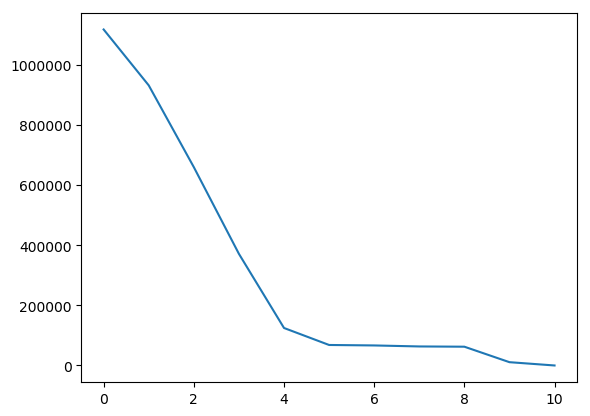

Converged after 11 iterations.

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000050B9FC88>

In [92]:
A = getA()
x, history = solve(A, [1.;1.;1.], prolongation2(A))
print(history)
#keys(history.data)
plot(history.data[:resnorm])